# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Jean-Baptiste PROST <br>
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

[Scikit-image](http://scikit-image.org/docs/stable/api/api.html) reference.

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

import skimage.io
import skimage.exposure
from skimage.morphology import watershed
import skimage.morphology
import skimage as sk
from skimage import color
from skimage.measure import label, regionprops

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'

if not os.path.isdir(data_base_path): #if the file has already been extracted
    
    tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')


    with tarfile.open(tar_path, mode='r:gz') as tar:
        tar.extractall(path=data_base_path)
        
else:
    print('Files already extracted')
    pass

Files already extracted


# Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

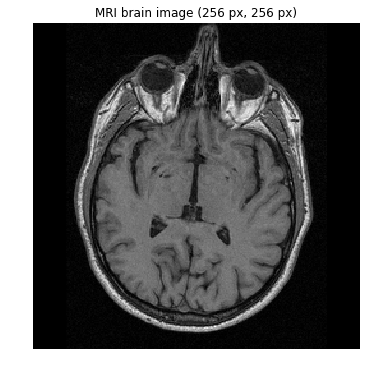

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
#load in grayscale
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True)
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing

In this section, we implement a region growing algorithm. <br>
The algorithm starts at a given pixel (`seed`) that is chosen to be in the region of interest. Then, it will assign the same value to every pixels that satisfy the following conditions (iteratively):
* being in the neighbourhood of a seed-related point (8 closest pixels)
* validate the similarity criterion based on the gray value. `loDiff` and `upDiff` define the range of the gray value to be [*seed gray value* - 7; *seed gray value* + 8].

The `cv2.floodFill`function from OpenCv is used.


In [4]:
#Region growing using cv2 Floodfill
seed=(100,100)

#add padding 
mask = np.zeros((brain_im.shape[0]+2, brain_im.shape[1]+2), np.uint8)

#region growing
a = cv2.floodFill(brain_im.copy(), mask, seedPoint=seed, newVal=(255,0,0), loDiff=(7), upDiff=(8))

#storing output image
grown_region_im = a[1]

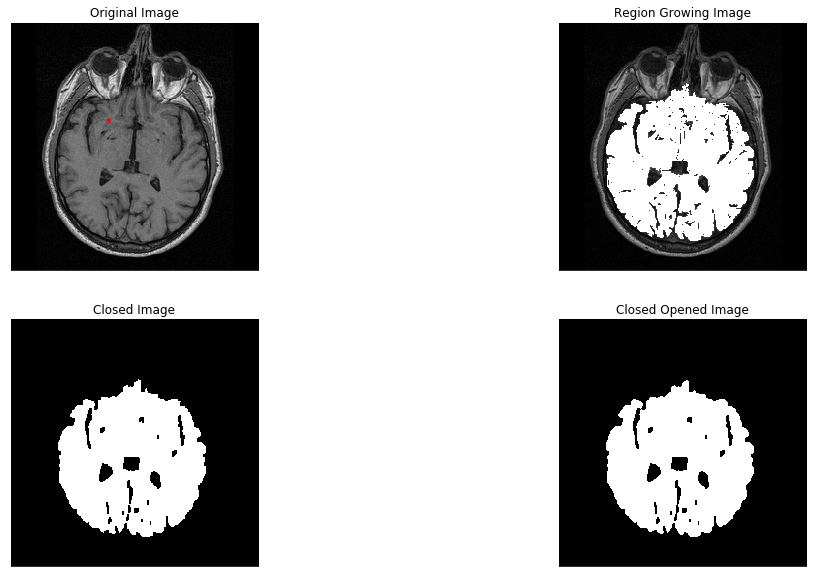

In [5]:
#Keeping image as binary output
binary_image= grown_region_im<255

#Closing holes inside brain
kernel_closing = np.array([[0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0]],dtype=np.uint8)

closed_img = skimage.morphology.binary_closing(~binary_image, selem=kernel_closing)

#opening
kernel_opening = np.array([[0, 1,  0],
                   [1, 1, 1],
                   [0, 1, 0]],dtype=np.uint8)
closed_opened_img = skimage.morphology.binary_opening(closed_img, selem=kernel_opening)

#plotting
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.imshow(brain_im, cmap='gray')
plt.scatter(seed[0], seed[1], marker='o', s=10, color='r')
plt.xticks([])
plt.yticks([])
plt.title('Original Image')

plt.subplot(2,2,2)
plt.imshow(grown_region_im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Region Growing Image')

plt.subplot(2,2,3)
plt.imshow(closed_img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Closed Image')

plt.subplot(2,2,4)
plt.imshow(closed_opened_img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Closed Opened Image')

plt.show()

Note that the inital pixel for region growing is indicated with a red dot on the original picture.<br>
The final area is found by the final number of white pixels

In [6]:
print('The brain region has a {} pixel area.'.format(closed_opened_img.sum()))

The brain region has a 16962 pixel area.


### 1.3 Contour detection

The `skimage` library provides several edge detecting algorithms. To get an idea of their performance, several of them are tested below.


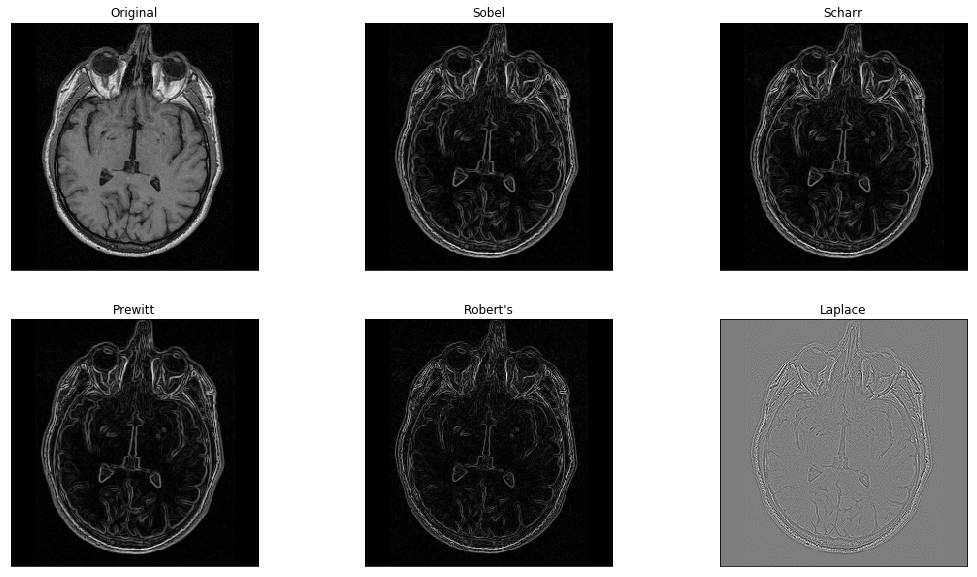

In [7]:
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True)

#different edge detecting algorithms
edge_functions= [sk.filters.sobel, sk.filters.scharr, sk.filters.prewitt, sk.filters.roberts, sk.filters.laplace]
edge_labels=['Sobel', 'Scharr','Prewitt','Robert\'s', 'Laplace']

#plotting
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.imshow(brain_im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Original')

for i, fct in enumerate(edge_functions):
    edge_tmp=fct(brain_im) #apply the different functions
    
    plt.subplot(2,3,i+2)
    plt.imshow(edge_tmp, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(edge_labels[i])
    

By testing several edge-detection method, the results are very similar. The laplacian method outputs values ranging close to zeros while other methods have larger ranges of values.

### Sobel method

The **Sobel** methode is based on the first derivative according to the X  and  Y axis. The magnitude of both derivative is computed. The points where the magnitude is higher are considered to be the edges. 


In the following code, the **watershed** algorithm treats the pixels values as a 3D map. <br>
The region of interest is target within a ragne of grayscale value creadting the *markers*.
They are provided to the function and use to determine the local minima of the picture that will form "bassins" were a specific value will "flood" to create regions. Regions within boundaries (defined by markers) will be filled with a specific value.




In [8]:
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True,)

#sobel edge detection
edge_detected=sk.filters.sobel(brain_im)

#determining the edge of brain vs. background
markers = np.zeros_like(edge_detected)
markers[brain_im < 45] = 1
markers[brain_im > 58] = -2

#filling the regions (between borders)
segmentation = watershed(edge_detected, markers)


#morpholygy steps to separate the filled regions
binary_op_array=np.ones((3,3))
segmentation_err=sk.morphology.binary_erosion(segmentation-1,binary_op_array)
binary_close_array=np.ones((3,3))
segmentation=sk.morphology.binary_closing(segmentation_err,binary_close_array)

#pixels value for background
background_val=0

#put labels to connected regions
regions,nb_regions=sk.measure.label(segmentation, connectivity=2, background=background_val, return_num=True)

#retrieves the areas of the filled regions
areas=[region.area for region in sk.measure.regionprops(regions)]

#brain regions
final_region=np.zeros_like(regions)
#label of max area
final_region[regions==np.argmax(areas)+1] = 1

#closing to fill holes
binary_close_array=np.ones((5,5))
final_region=sk.morphology.binary_closing(final_region,binary_close_array)

print('The Brain region (label={}) has a {} px area'.format(np.argmax(areas), sum(sum(final_region))))

The Brain region (label=23) has a 15288 px area


**Plotting**

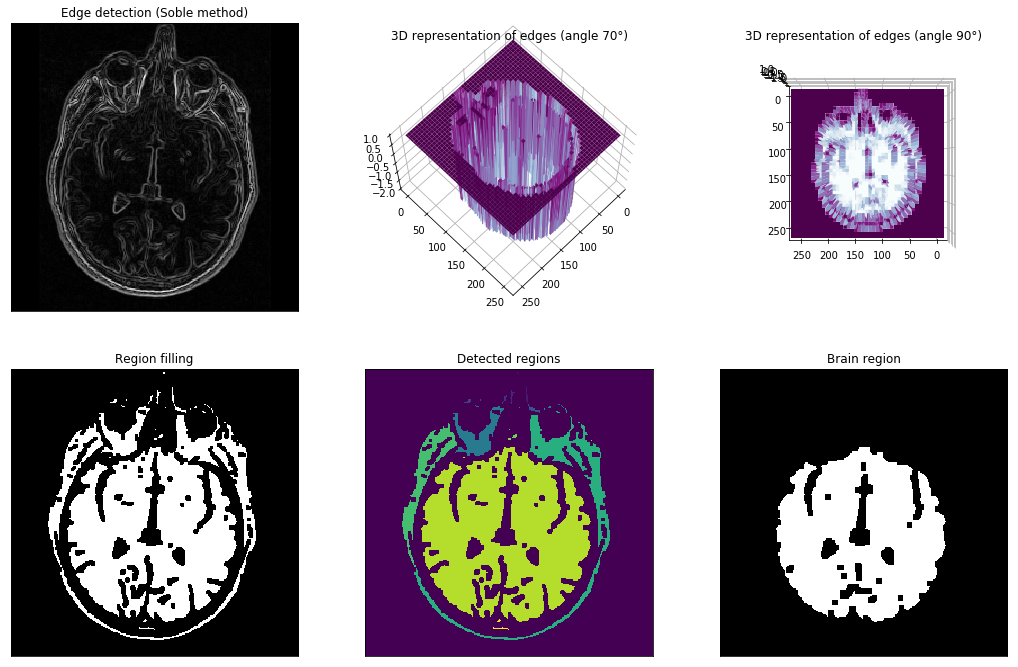

In [12]:
#For 3d ploting
X = np.arange(0, brain_im.shape[0], 1)
Y = np.arange(0,brain_im.shape[0], 1)
X, Y = np.meshgrid(X, Y)
Z=markers

#--- First ---#
plt.figure(figsize=(18,18))
plt.subplot(3,3,1)
plt.imshow(edge_detected, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Edge detection (Soble method)')

#--- Second ---#
ax=plt.subplot(3,3,2, projection='3d')
ax.plot_surface(X, Y, Z, cmap='BuPu',linewidth=0, antialiased=True)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=70, azim=(45))
plt.title('3D representation of edges (angle 70°)')

#--- Thrid ---#
ax = plt.subplot(3, 3, 3, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='BuPu',linewidth=0, antialiased=True)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=90, azim=(90))
plt.title('3D representation of edges (angle 90°)')


#--- Fourth ---#
plt.subplot(3,3,4)
plt.title('Region filling')
plt.xticks([])
plt.yticks([])
plt.imshow(segmentation, cmap='gray')


#--- Fifth ---#
plt.subplot(3,3,5)
plt.imshow(regions)
plt.xticks([])
plt.yticks([])
plt.title('Detected regions')

#--- Sixth ---#
plt.subplot(3,3,6)
plt.xticks([])
plt.yticks([])
plt.imshow(final_region, cmap='gray')
plt.title('Brain region')

plt.show()

### Discussion

Both region growing and contour detection give ± the same results. The region growing algorithm seems simpler than the second algorithm (as a single setp is need to have a sufficient results). Moreover it could be more robust by adding other criterion to to define similarity between pixels.


Another countour detection method below, will provide the same results.

### 1.4 Additional method(s)

####  1.4.1  Edge detection with Laplacian of Gaussian method

The same method as Sobel's is applied with a different kind of edge detecting algorithm. 


The **Laplacian of the Gaussian** is based on the following steps:
* Filtering the image with a Gaussian filter. The larger the variance, the coarser will be the elemeters to be detected.
* The laplacian of the image is computed (second derivative)
* The zero-crossing points of the laplacians are found and set as the edges of the image

In [13]:
def get_neighbours_sign(img,i,j):
    """Retruns TRUE if one of the immediate surrounding neighbour has a 
    different sign.
    It enables to know if the considered img[i,j] point is a considered 
    as a zero-crossing point
    INPUT: the image IMG, the position of the considered pixel I, J."""
    
    sign_diff=False
    
    #for every neighbour
    for ii in [i-1,i,i+1]:
        for jj in [j-1,j,j+1]:
          
            # if their product has a neg sign
            if img[i,j]*img[ii,jj] <=0:
                sign_diff=True
            break
        break
    
    return sign_diff

def zero_crossing(img):
    """Returns 1 for the points where a zero-cossing of the laplacian 
    occurs.
    Intput: image"""
    
    z_crossed=np.zeros_like(img)
    
    #adds padding for the edges points
    img=np.pad(img,((1,1),(1,1)), mode='constant', constant_values=0)
    
    #for every pixel of the image ...
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            
            if img[i,j]==0: #if the laplacian is zero
                z_crossed[i-1,j-1]=1
                
            elif get_neighbours_sign(img,i,j): #if the sign of the neighbours is differnet
                z_crossed[i-1,j-1]=1
            
            else:
                pass
    
    return z_crossed

In [25]:
#loading the image
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True)

#apply a gaussian denoising
denoised=sk.filters.gaussian(brain_im, sigma=2.5)

#computes the laplacian
laplace_im=sk.filters.laplace(denoised)

#gets the zero-crossing points
edge_detected=zero_crossing(laplace_im)

#determining the edge of brain vs. background (grayscale value on
#the original image)
markers = np.zeros_like(laplace_im)
markers[brain_im < 45] = 1
markers[brain_im > 58] = -2

#filling the regions (between borders)
segmentation = watershed(edge_detected,markers)

#morphology steps to separate the filled regions
binary_op_array=np.ones((5,5))
segmentation_err=sk.morphology.binary_erosion(segmentation-1,binary_op_array)
binary_close_array=np.ones((6,6))
segmentation=sk.morphology.binary_closing(segmentation_err,binary_close_array)

#identifying connected regions
background_val=1
regions,nb_regions=sk.measure.label(~segmentation, background=background_val,connectivity=2, return_num=True)

#retrieves the areas of the filled regions
areas=[region.area for region in sk.measure.regionprops(regions)]

#brain regions
final_region=np.zeros_like(regions)
#label of max area
final_region[regions==np.argmax(areas)+1] = 1

#closing to fill holes
binary_close_array=np.ones((8,8))
final_region=sk.morphology.binary_closing(final_region,binary_close_array)

print('The Brain region (label={}) has a {} px area'.format(np.argmax(areas), sum(sum(final_region))))

The Brain region (label=5) has a 13869 px area


**Plotting**

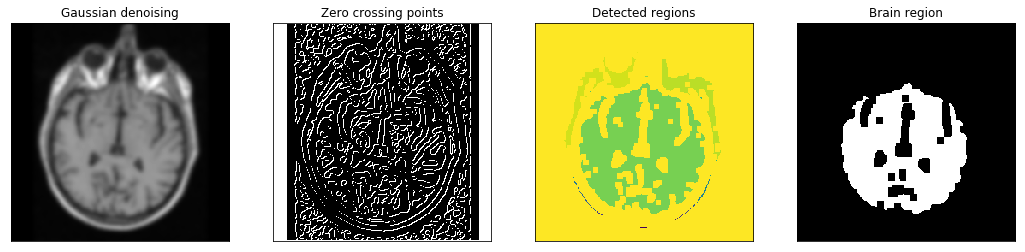

In [26]:
plt.figure(figsize=(18,10))

plt.subplot(1,4,1)
plt.imshow(denoised, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Gaussian denoising')

plt.subplot(1,4,2)
plt.imshow(edge_detected, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Zero crossing points')

plt.subplot(1,4,3)
plt.imshow(regions, cmap='viridis_r')
plt.xticks([])
plt.yticks([])
plt.title('Detected regions')

plt.subplot(1,4,4)
plt.imshow(final_region, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Brain region')

plt.show()

**Influence of the Gaussian filter variance** <br>
When the `sigma` parameter of the Gaussian filter is increased, the number of zero-crossing points decreases the amount of details in the image. A trade-off has been found to detect sufficently relevant edges with :
sigma = 2.5

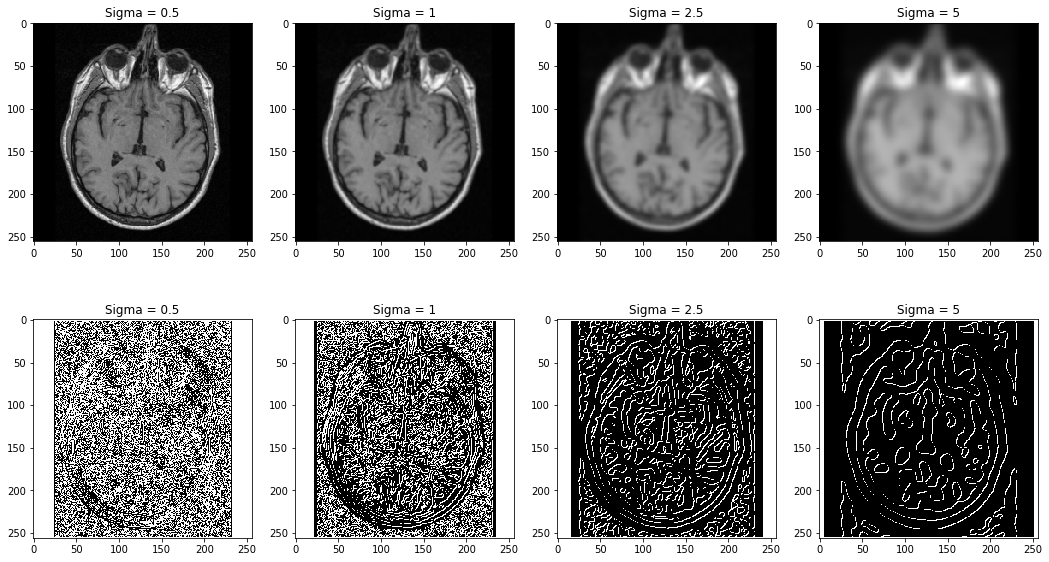

In [24]:
#loading the image
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True)

plt.figure(figsize=(18,10))

i=1
for sigma in [0.5, 1, 2.5, 5] :
    #apply a gaussian denoising
    denoised=sk.filters.gaussian(brain_im, sigma=sigma)
    #computes the laplacian
    laplace_im=sk.filters.laplace(denoised)
    #gets the zero-crossing points
    edge_detected=zero_crossing(laplace_im)
    
    plt.subplot(2,4,i)
    plt.imshow(denoised, cmap='gray')
    plt.title('Sigma = {}'.format(sigma))
    
    plt.subplot(2,4,i+4)
    plt.imshow(edge_detected, cmap='gray')
    plt.title('Sigma = {}'.format(sigma))
    
    i+=1

#### 1.4.2  Use of morphology and thresholding only

In [46]:
binary_image = (brain_im < 79) & (brain_im > 60)

kernel = np.ones((3,3))
filtered_img = skimage.filters.median(binary_image, selem=kernel)

kernel_opening = np.array([[0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0]],dtype=np.uint8)

kernel_closing = np.array([[0,0,1,1,1,0,0],
                         [0,0,1,1,1,0,0],
                         [1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1],
                         [0,0,1,1,1,0,0],
                         [0,0,1,1,1,0,0]], dtype=np.uint8)
opened_img = skimage.morphology.binary_opening(filtered_img, selem=kernel_opening)

kernel_closing = np.ones((20,20))
closed_img = skimage.morphology.binary_closing(opened_img, selem=kernel_closing)

closed_opened_img = skimage.morphology.binary_opening(closed_img, selem=np.ones((10,10)))

print('Brain area : {} pixels'.format(closed_img.sum()))

Brain area : 17011 pixels


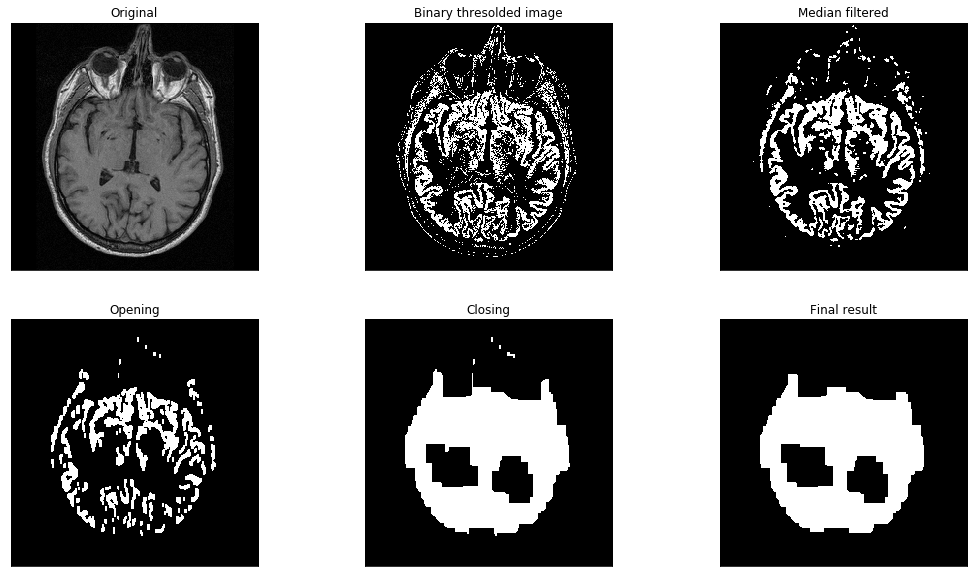

In [47]:
#plotting
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.imshow(brain_im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Original')

plt.subplot(2,3,2)
plt.imshow(binary_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Binary thresolded image')

plt.subplot(2,3,3)
plt.imshow(filtered_img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Median filtered')

plt.subplot(2,3,4)
plt.imshow(opened_img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Opening')

plt.subplot(2,3,5)
plt.imshow(closed_img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Closing')

plt.subplot(2,3,6)
plt.imshow(closed_opened_img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Final result')


plt.show()

With a simple methode of morphology step, a faire result is found.

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [28]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


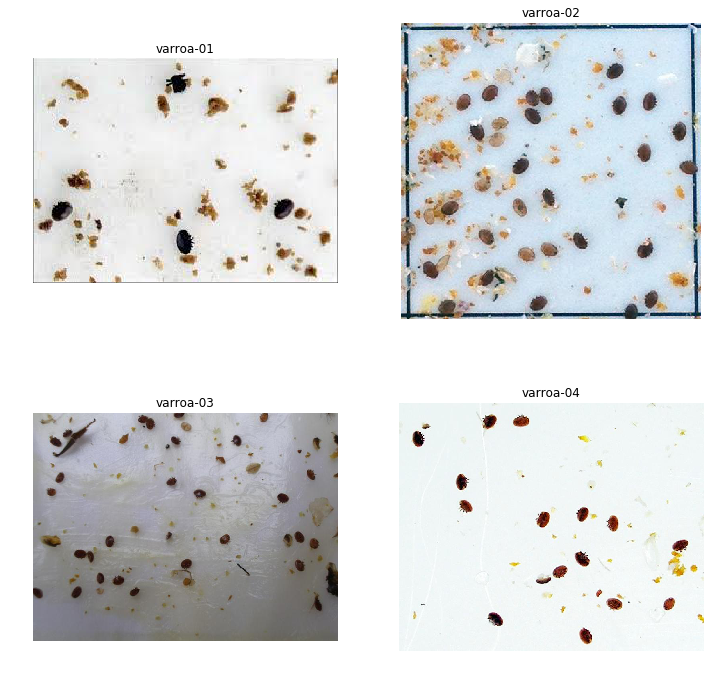

In [29]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [30]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [31]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

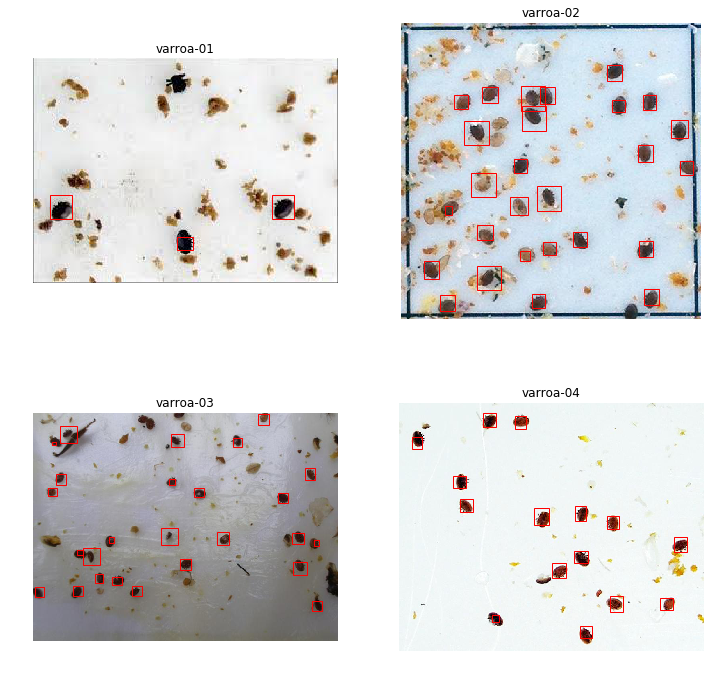

In [32]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

In [33]:
def image_cleaning(image, threshold = 0.1, kernel_filtering = np.ones((4,4)), kernel_opening = np.ones((3,3)), plot=False, annot=False):
    '''
    This functions applyes a threshold on a gray scale image, filters this obtained image and then opens it.
    It returns the filtered-opened image and plots the evolution if plot == 1
    
    args:
    image [np.array] : a grayscale image 
    threshold [float] : a threshold for selecting dark shapes
    kernel_filtering [np.array] : an array used as kernel for median filtering
    kernel_opening [np.array] : used as kernel for morphologicyl opening
    plot [bool] : Bool to decide wether to plot or not
    annot [xlms] : annotations for the boxes 
    
    output:
    im [np.array] : the image after threshold, filtering, opening and closing
    '''
    
    images_list = []
    titles_list = []
    
    #images_list.append(image)
    #titles_list.append('Original Image')
    #creating gray scale image
    grayscale_img = color.rgb2gray(image)
    images_list.append(grayscale_img)
    titles_list.append('Grayscale Image')

    #creating gray scale image
    threshold_img = grayscale_img < threshold
    images_list.append(threshold_img)
    titles_list.append('Thresholded Image ' + str(threshold))

    #median filtering
    filtered_img = skimage.filters.median(threshold_img, selem=kernel_filtering)
    images_list.append(filtered_img)
    titles_list.append('Median-Filtered Image')
    
    #opening to remove holes
    opened_img = skimage.morphology.binary_opening(filtered_img, selem=kernel_opening)
    images_list.append(opened_img)
    titles_list.append('Filtered-Opened Image')


    if plot == True:
        
        fig, axes = plt.subplots(1, 4, figsize=(18, 18))
        
        i=0
        for ax in axes.ravel():
            ax.imshow(images_list[i], cmap='gray')
            ax.set_title(titles_list[i])
            ax.axis('off')
            
            #if we have the real boxes, add them to pictures
            if annot != False:
                for anno in annotations:
                    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)
            i=i+1
        plt.show()
    return opened_img


For each image specific thresholds and mophology kernels are tuned.

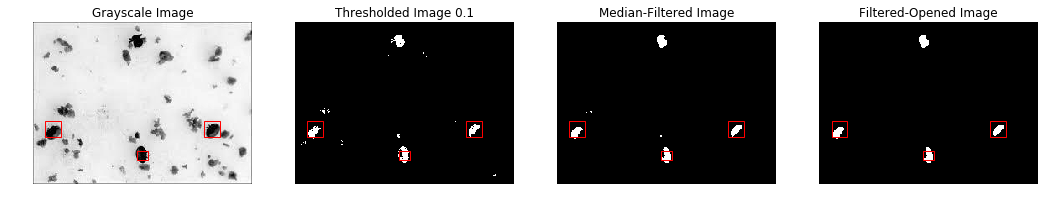

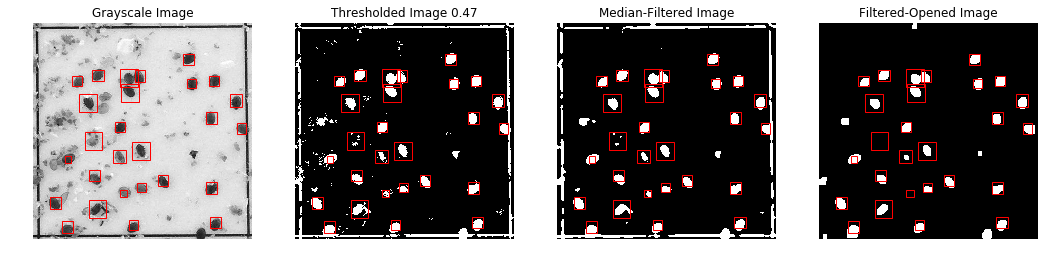

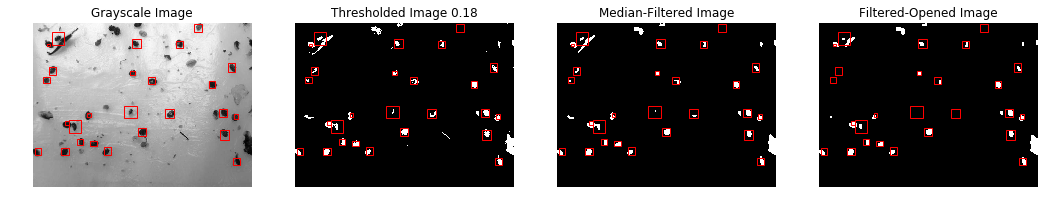

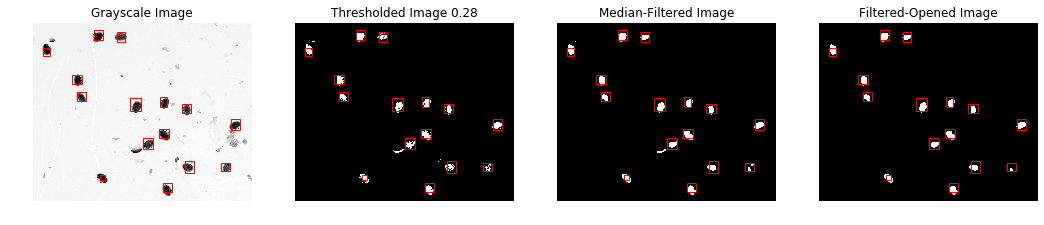

In [35]:
#specific threshold for each image
thresholds = [0.1, 0.47, 0.18, 0.28]

filtering_ks = [np.ones((4,4)),\
               np.ones((6,6)),\
               np.array( [[0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0]], dtype=np.uint8),\
              np.array( [[0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0]], dtype=np.uint8)]

opening_ks = [np.ones((3,3)),\
                np.ones((8,8)),\
              np.ones((6,6)),\
              np.array( [[0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0]], dtype=np.uint8)]

closing_ks = [np.ones((3,3)),\
               np.ones((5,5)),\
              np.ones((5,5)),\
              np.ones((5,5))]

#image cleaning and plotting
images_bee = []
for im, thre, filt, op, annotations in zip(ic, thresholds, filtering_ks, opening_ks, annotations_xmls):
    images_bee.append(image_cleaning(im, thre, kernel_filtering=filt, 
                                     kernel_opening=op, plot=True, annot=annotations))
    

#### We now have clearly separated shapes, we need to count the number of shapes we have

In [36]:
def plotting_images_w_boxes(list_of_images, list_of_boxes, colors, names, legends):
    '''
    Plots multiple boxes type of a given color for a given color
    
    args:
    list_of_images [np.array] : images
    list_of_boxes [[[regionprops or dict]]] : boxes to plot
    color [str] : list of string (same len as list_of_boxes)
    names [str] : list of string with names for images (same len as list_of_images)
    legend [str] : list of legends for boxes
    '''
    fig, axes = plt.subplots(int(len(list_of_images)/2), int(len(list_of_images)/2), figsize=(18, 12))
    
    #for images and axes
    for image, ax, nm, i in zip(list_of_images, axes.ravel(), names, range(len(list_of_images))):
        
        ax.imshow(image, cmap = 'gray')
        ax.set_title(nm)
        ax.axis('off')
        
        #go over all boxes
        for type_of_boxes, c in zip(list_of_boxes, colors):
            
            for box in type_of_boxes[i]:
                
                #if boxes are regionprops : images found and images keps
                if isinstance(box, skimage.measure._regionprops._RegionProperties):
                    minr, minc, maxr, maxc = box.bbox
                    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor=c, linewidth=2)
                    ax.add_patch(rect)
                
                #if dictionary, ground truth    
                elif isinstance(box, dict):
                    rect = patches.Rectangle((box['bbox'][0], box['bbox'][1]), box['bbox'][2], box['bbox'][3],
                    linewidth=1,edgecolor=c,facecolor='none')
                    ax.add_patch(rect)

    for l, c, j in zip(legends, colors, range(len(legends))):    
        plt.text(0, -j*40, l,
         {'color': c, 'fontsize': 10, 'ha': 'left', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})

Plotting all objects in an image

-------------------------------------------------------
Counted: 4
Actual: 3
Accuracy: 0.75


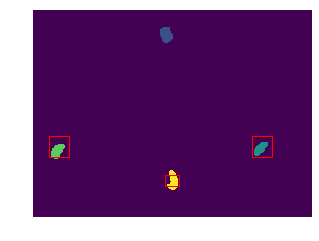

-------------------------------------------------------
Counted: 30
Actual: 27
Accuracy: 0.9


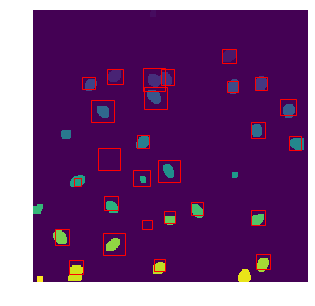

-------------------------------------------------------
Counted: 29
Actual: 26
Accuracy: 0.9


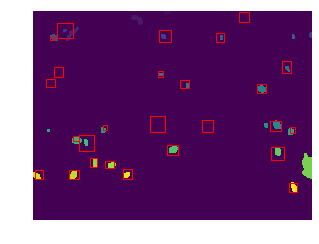

-------------------------------------------------------
Counted: 15
Actual: 15
Accuracy: 1.0


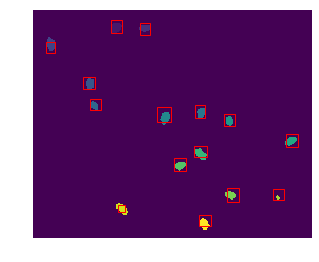

In [37]:

labels_img = []

#for images and corresponding ground truth
for larvea_im, annotations in zip(images_bee, annotations_xmls):
    labeled,b = skimage.measure.label(larvea_im, return_num=True)
    labels_img.append([labeled,b])
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    i=0
    #going over al boxes
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        i=i+1
    print("-------------------------------------------------------") 
    print('Counted:', b)
    print('Actual:', i)
    print('Accuracy:', np.round(i/b,2))
    ax.axis('off')
    ax.imshow(labeled, cmap='viridis')
    
    plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

In [39]:
def create_bounding_boxes(image):
    '''
    Returns bounding boxes from labeled image
    '''
    regions = []
    for region in regionprops(image):
        # take regions with large enough areas
        if region.area >= 70:
            # draw rectangle around segmented coins
            regions.append(region)  
    return regions   

Create bounding boxes

In [40]:
region_img = []
for image in labels_img:
    region_img.append(create_bounding_boxes(image[0].copy()))

Red boxes are the ground-truth, blue ones are the detected insects

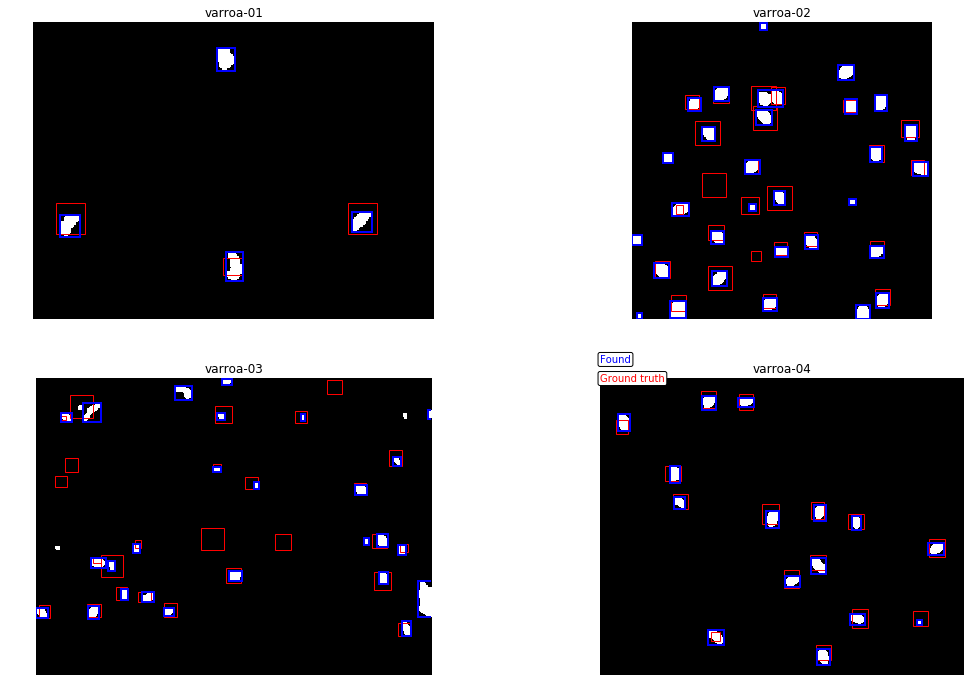

In [41]:
boxes_to_plot = [annotations_xmls, region_img]
#plot
plotting_images_w_boxes(images_bee, boxes_to_plot,['r','b'], im_names, ['Ground truth', 'Found'])

In [42]:
def bb_intersection_over_union(boxA, boxB):
    '''
    Given two bounding boxex, calculates IoU
    
    args:
    boxA (int,int,int,int) : (ymin, xmin, ymax, xmax)
    boxB (int,int,int,int) : (ymin, xmin, ymax, xmax)
    
    output:
    IoU (float) : IoU of boxA and boxB
    
    credits to Adrian Rosebrock : https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        
    if interArea > 0:
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
    else :
        iou = 0
        
    return iou

In [43]:
def IoU_bbox(detected, ground_truth):
    '''
    Creates a matrix with rows corresponding to the detected objects and the columns 
    corresponding to the ground_truth. The i,j element of the matrix correspond to the IoU
    score between the detected box i and the gorund truth j.
    An additional column is added (last position) to represent the detect boxes that
    do not match any ground truth (their score is -1)
    An additional row is added (last position) correponding to the ground-truth that 
    do not intersect with any detected ones (their score is -2).
    
    args:
    detected : detected boxes
    ground_truth : the ground_truth boxes.
    
    returns:
    matrix of IoU scores.
    '''
    nb_detected = len(detected)
    nb_true = len(ground_truth)
    iou_matrix = np.zeros((nb_detected+1, nb_true+1))



    #for each detected box, go over all true boxes
    for i in range(nb_detected) :
        
        detected_box = image_detected[i]
        
        for j in range(nb_true):  
            region = image_true[j]

            #modyfying bbox of true to satisfy bbox format or regionprop
            bbox_modified = (region['bbox'][1], region['bbox'][0], \
                            region['bbox'][1] + region['bbox'][3], \
                            region['bbox'][0] + region['bbox'][2])
            #calculates IoU
            iou = bb_intersection_over_union(detected_box.bbox, bbox_modified)
            
            iou_matrix[i,j] = iou
            
        
        #last column is -1: detected but not ground-truth : false positives    
        #if iou_matrix.sum(axis=1)[i] == 0:
        if sum(iou_matrix[i,:])==0:
            iou_matrix[i,j+1] = -1
    
    #last row is -2: ground-truth but not detected: false negative       
    iou_matrix[-1, [iou_matrix.sum(axis=0) == 0][0]] = -2
    
    #element at 'false postive' and 'false negative' column intersection
    iou_matrix[-1,-1] = 0
    
    return iou_matrix


We calculte only once the IoU score for each image. Adjusting the threhsold for true positive will not need to compute all the operation again

In [48]:
matrices = []
#computes the IoU score for every box in each image.
for image_detected, image_true in zip(region_img, annotations_xmls):
    matrices.append(IoU_bbox(image_detected, image_true))

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

In [49]:
def plot_boxes_from_threshold(kept_boxes, image, found_boxes, true_boxes, images):
    '''
    Plot boxes for given images
    
    ARGS:
    kept_boxes   |list|     : list of boxes kept from threshold
    images       |np.array| : image of bees
    found_boxes |list|      : list regioprops corresponding to the boxes found
    true_boxes  |list|      : list of dict cotaining real boxes
    image        |np.array| : binary image of bees
    '''
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 18))
    
    axes[0].imshow(images)
    axes[1].imshow(image, cmap = 'gray')

    for found_box in found_boxes:
        minr, minc, maxr, maxc = found_box.bbox
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                          fill=False, linewidth=2, color='b')
        axes[1].add_patch(rect)
        
    for true_box in true_boxes:
        rect = patches.Rectangle((true_box['bbox'][0], true_box['bbox'][1]), \
                                 true_box['bbox'][2], true_box['bbox'][3],
                                linewidth=1,edgecolor='r',facecolor='none')
        axes[1].add_patch(rect)
        rect = patches.Rectangle((true_box['bbox'][0], true_box['bbox'][1]), \
                                 true_box['bbox'][2], true_box['bbox'][3],
                                linewidth=1,edgecolor='r',facecolor='none')
        axes[0].add_patch(rect)
        
    for kept_box in kept_boxes:
        minr, minc, maxr, maxc = found_boxes[kept_box[0]].bbox
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                          fill=False, linewidth=2, color='gold')
        axes[1].add_patch(rect)
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                          fill=False, linewidth=2, color='gold')
        axes[0].add_patch(rect)
        
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.show()

In [106]:
def precision_recall_f_score(matrices, threshold, images, found_boxes, true_boxes, full_images, im_names, plot=False):
    '''
    From matrice calculates TP, FP and FN rates for all images for a given threshold and plot
    the boxes given if asked.
    
    ARGS
    matrices |list of np.array| : contains values of IoB boxes for each found and real boxes
    threhold |float|            : IoU threshold given
    found_boxes |list|          : list regioprops corresponding to the boxes found
    true_boxes  |list|          : list of dict cotaining real boxes
    full_images |[np.array]|    : images
    im_names |list|             : list of image names
    plot |bool|                 : selecting if we plot or not
    
    RETURNS
    dataframe: |panda dataframe| precision, recall and f1 for each image
    
    '''
    dataframe=pd.DataFrame()
    
    for i in range(len(images)):
        im = images[i]
        iou_matrix=matrices[i]
        
        #where the IoU score is above the threshold
        true_positives_boxes = np.argwhere(iou_matrix > threshold)
        
        #gets the box with insufficient intersection score or ground truth that
        #do not intersect with a detected one (= -2 in the matrix)
        false_negatives_boxes = np.argwhere(((iou_matrix>0) & (iou_matrix<threshold))  | (iou_matrix == -2))
        
        #get rid of element that have a higher IoU score with other boxes
        false_negatives_boxes= [box for box in false_negatives_boxes if box not in true_positives_boxes]
        
        
        false_positives_boxes = np.argwhere(iou_matrix == -1)
        
        #calculating the rates
        tp = len(true_positives_boxes)
        fp = len(false_positives_boxes)
        fn = len(false_negatives_boxes)
        
        #statistics
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2*(precision*recall)/(precision+recall)
        
        print('--'*33)
        print(' '*27+'IMAGE', i+1,)
        print('True positives =', tp, \
              '; False positives =', fp,\
              '; False negatives =', fn)
        print('Precision = {} ; Recall = {} ; F1 = {}'.format(np.round(precision,2),
                                                              np.round(recall,2),
                                                              np.round(f1,2)))
        if plot == True:
            plot_boxes_from_threshold(true_positives_boxes, im, found_boxes[i], true_boxes[i], ic[i])

        
        dataframe.loc['f1',im_names[i]]=f1
        dataframe.loc['precision',im_names[i]]=precision
        dataframe.loc['recall',im_names[i]]=recall

    return dataframe

------------------------------------------------------------------
                           IMAGE 1
True positives = 3 ; False positives = 1 ; False negatives = 0
Precision = 0.75 ; Recall = 1.0 ; F1 = 0.86


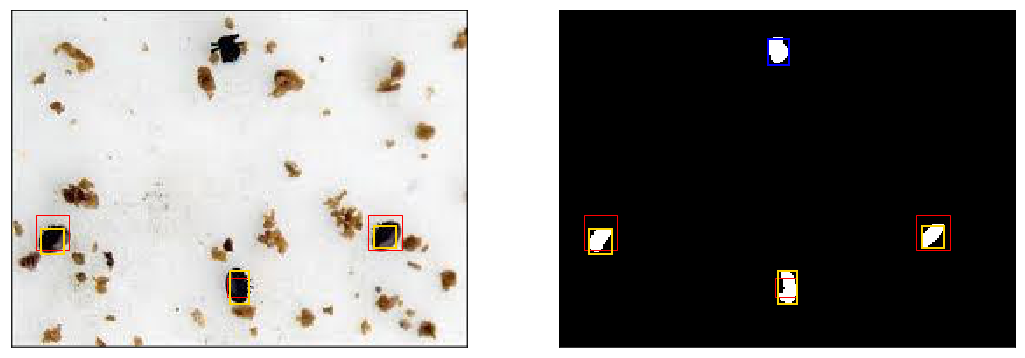

------------------------------------------------------------------
                           IMAGE 2
True positives = 25 ; False positives = 6 ; False negatives = 2
Precision = 0.81 ; Recall = 0.93 ; F1 = 0.86


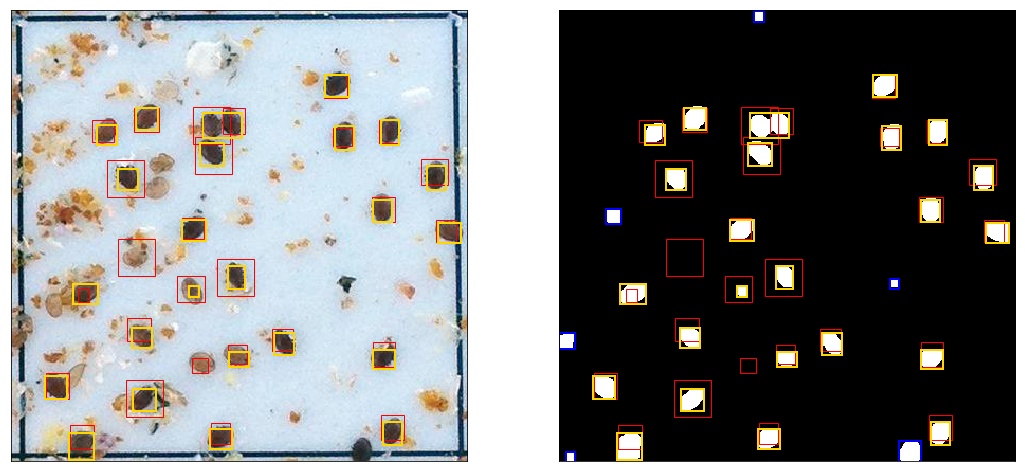

------------------------------------------------------------------
                           IMAGE 3
True positives = 21 ; False positives = 5 ; False negatives = 5
Precision = 0.81 ; Recall = 0.81 ; F1 = 0.81


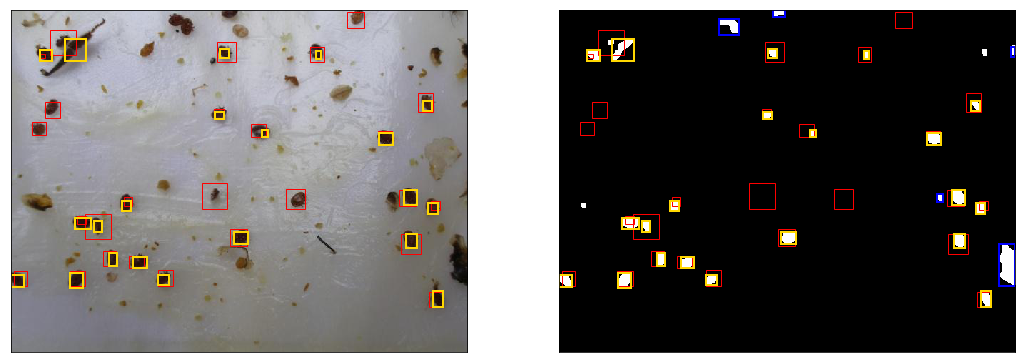

------------------------------------------------------------------
                           IMAGE 4
True positives = 15 ; False positives = 0 ; False negatives = 0
Precision = 1.0 ; Recall = 1.0 ; F1 = 1.0


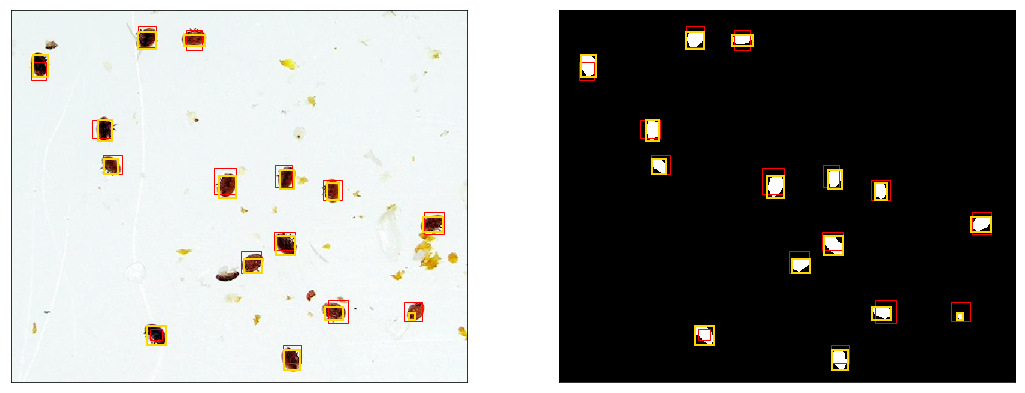

In [107]:
threshold=0.1
df_01=precision_recall_f_score(matrices, threshold, images_bee,
                               region_img, annotations_xmls, ic,im_names, True)

------------------------------------------------------------------
                           IMAGE 1
True positives = 3 ; False positives = 1 ; False negatives = 0
Precision = 0.75 ; Recall = 1.0 ; F1 = 0.86


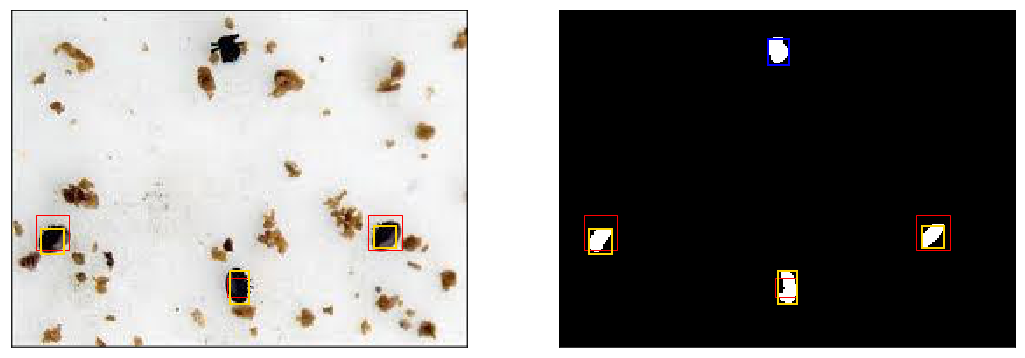

------------------------------------------------------------------
                           IMAGE 2
True positives = 19 ; False positives = 6 ; False negatives = 7
Precision = 0.76 ; Recall = 0.73 ; F1 = 0.75


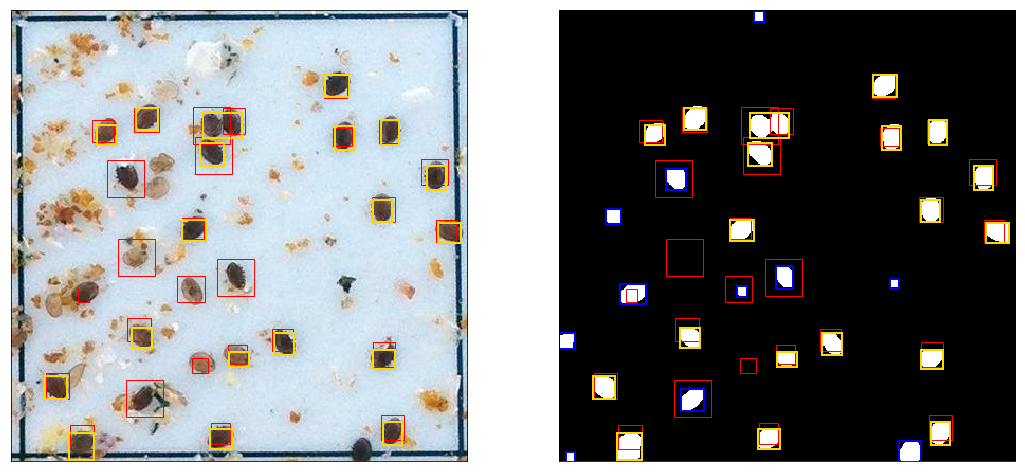

------------------------------------------------------------------
                           IMAGE 3
True positives = 10 ; False positives = 5 ; False negatives = 18
Precision = 0.67 ; Recall = 0.36 ; F1 = 0.47


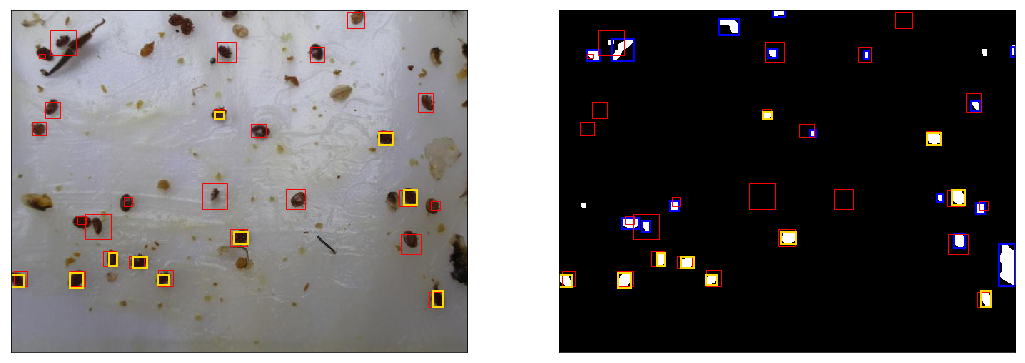

------------------------------------------------------------------
                           IMAGE 4
True positives = 13 ; False positives = 0 ; False negatives = 2
Precision = 1.0 ; Recall = 0.87 ; F1 = 0.93


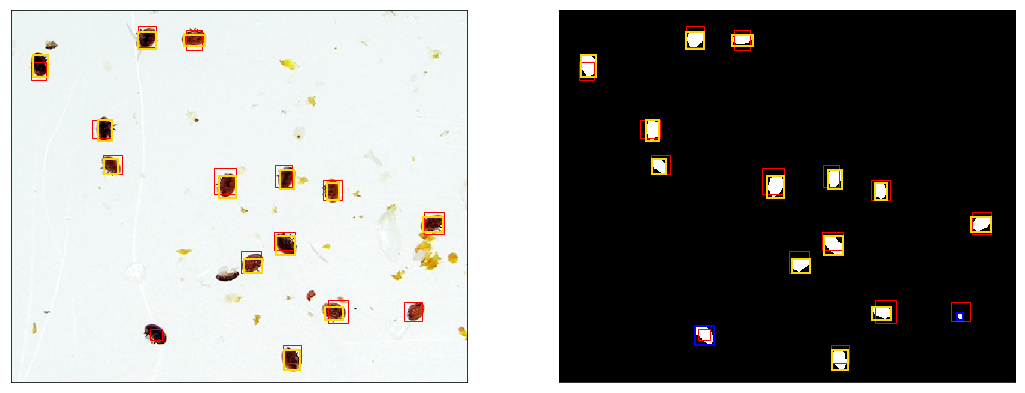

In [108]:
threshold=0.4
df_04=precision_recall_f_score(matrices, threshold, images_bee,
                               region_img, annotations_xmls, ic,im_names, True)

We can see that keeping a low threshold gives much better results. This is due to the fact that our boxes tend to be better fitted to the shape of the larvea while the ground truth are sometimes too tight or too loose. This means that while we find correct boxes, the difference in size removes good boxes for a threshold too high when the ground truth sizes do not correspond to the larvea shape.


On the other hand, lowering the threshold might have increase the rate of False Positive. But, in our system, small or large threshold does not affect this number.

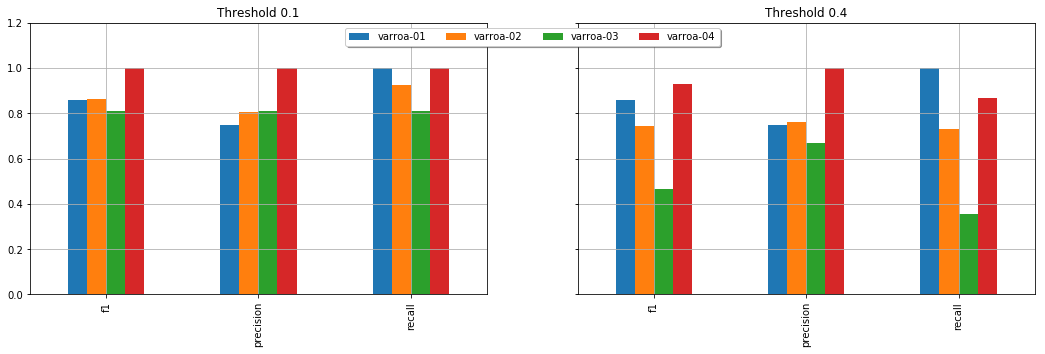

In [145]:
fig, ax= plt.subplots(1,2, sharex=True, sharey=True, figsize=(18,5))

df_01.plot.bar(ax=ax[0])
ax[0].set(xlabel='', title='Threshold 0.1' )
ax[0].set_ylim([0, 1.2])
ax[0].get_legend().remove()
ax[0].grid()


df_04.plot.bar( ax=ax[1])
ax[1].set(xlabel='',title='Threshold 0.4')
ax[1].grid()
ax[1].legend(loc='upper center', bbox_to_anchor=(-0.1, 1.),
          ncol=4, fancybox=True, shadow=True)

plt.show()

The recall is the most affected statistic as the number of true positive decreases. The IoU criterion become harder to satisfy, thus fwever number of insected are identifies as true positive.